<center> $\Large{\text{Portfolio Optimization}}$
<center> <b> MAARAF Oumayma

<b> <hr> 
<b> <hr>

# **Portfolio Optimization**
##       MAARAF Oumayma

In [ ]:
# installing necessary packages:

install.packages(c('quadprog','xts','nlshrink'))

In [ ]:
library(rvest)
library(tidyverse)
library(xts)
library(quadprog)
library(nlshrink)
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 100)

## Introduction : 

Harry Markowitz received a Nobel Prize for his pioneering theoretical contributions to financial economics and corporate finance. His innovative work established the underpinnings for Modern Portfolio Theory, an investment framework for the selection and construction of investment portfolios based on the maximization of expected portfolio returns and simultaneous minimization of investment risk.

In this Notebook, we will present an application of the Markowitz mean-variance model, in the case of a Portfolio consisting of 4 stocks of the Casablaca Stock exchange : (BCP, ATLANTASANAD, MarocTelecom, SOTHEMA) in a single-period market model of a horizon of 1 year.

**Getting historical data**


In [ ]:
#webscrapping historical data (Closing prices) from le boursier

tickers = c('BCP-P','ATLANTA-P', 'Maroc-Telecom', 'SOTHEMA')
names = c('BCP','ATLANTASANAD','MarocTelecom','SOTHEMA')

# Initialization : 
link = "https://www.leboursier.ma/details/action/BCP-P/historiques.html?date_from=2017-01-01&date_to=2020-12-31"
content = read_html(link)
rawtable = content%>%html_node("div.table-container")
table = html_table(rawtable,header = TRUE)
tableframe = as.data.frame(table)
date = as.Date(tableframe[,1],format='%d/%m/%Y')
adjclose = as.numeric(gsub(tableframe[,2],pattern = ',',replacement = '.'))
finaltable = xts(rev(adjclose),order.by=rev(date))
names(finaltable) = names[1]


In [ ]:
finaltable %>% head()

              BCP
2017-01-02 280.00
2017-01-03 280.05
2017-01-04 289.00
2017-01-05 300.00
2017-01-06 310.00
2017-01-09 320.00

In [ ]:
# the rest of data:

for(i in 2:length(tickers)){
  link = paste(paste('https://www.leboursier.ma/details/action/',tickers[i], sep=''), '/historiques.html?date_from=2017-01-01&date_to=2020-12-31', sep='')
  content = read_html(link)
  rawtable = content%>%html_node("div.table-container")
  table = html_table(rawtable,header = TRUE)
  tableframe = as.data.frame(table)
  date = as.Date(tableframe[,1],format='%d/%m/%Y')
  adjclose = as.numeric(gsub(gsub(tableframe[,2],pattern = ',',replacement = '.'),pattern=' ',replacement=''))
  finaltable = merge(finaltable,xts(rev(adjclose),order.by=rev(date)))
  names(finaltable)[i] = names[i]
}

## Data :

In [ ]:
finaltable %>% head()

              BCP ATLANTASANAD MarocTelecom SOTHEMA
2017-01-02 280.00        49.90       140.40    1181
2017-01-03 280.05        50.35       142.25    1181
2017-01-04 289.00        50.30       145.00    1181
2017-01-05 300.00        50.99       148.20    1181
2017-01-06 310.00        51.34       150.00    1181
2017-01-09 320.00        50.00       155.00    1181

## An overview of log-Closing prices

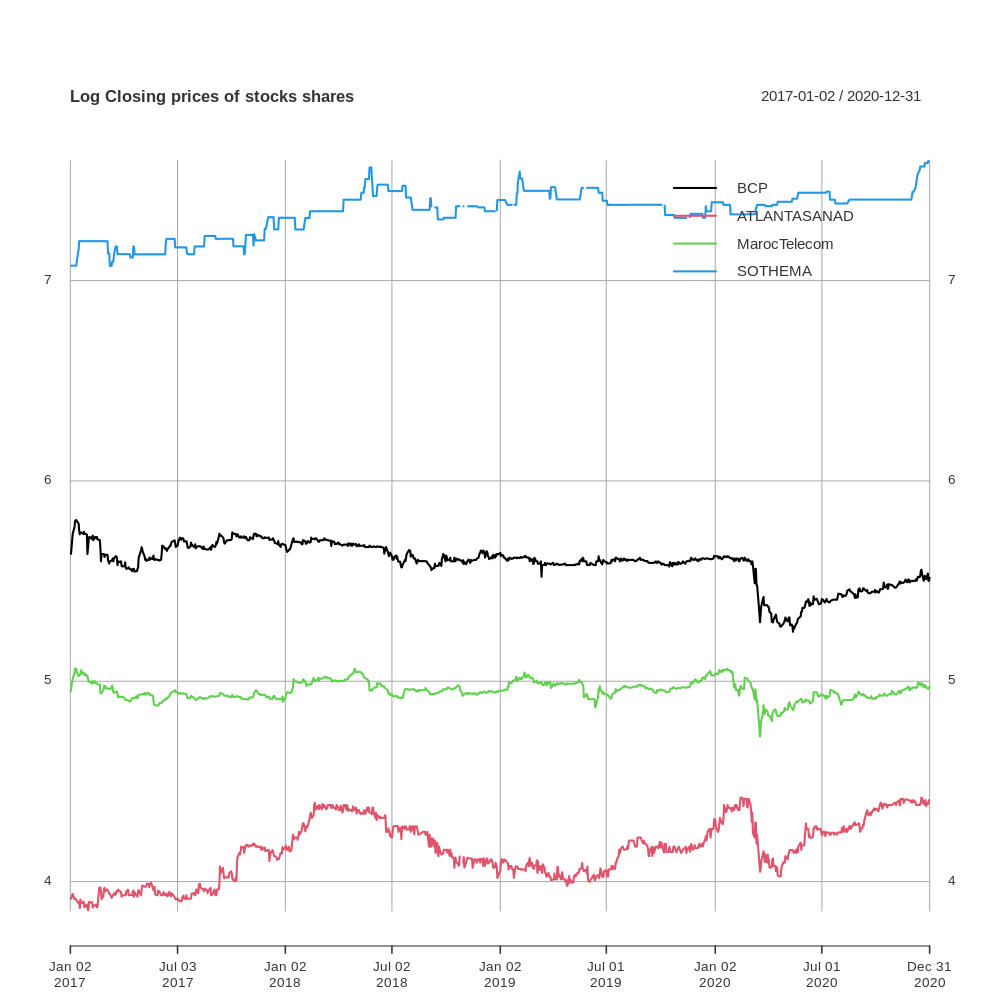

In [ ]:
p=plot.xts(log(finaltable), main='Log Closing prices of stocks shares')
addLegend(lty=1, lwd=2)

## Number of trading days / year

In [ ]:
nbTradingDays = period.apply(finaltable ,INDEX=endpoints(finaltable,on='years'), FUN=function(x) nrow(x))
nbTradingDays

           [,1]
2017-12-29  250
2018-12-31  247
2019-12-31  246
2020-12-31  250

## Continuously compounded returns (Daily basis): 

In [ ]:
logReturns <- diff(log(finaltable)) %>% na.omit()

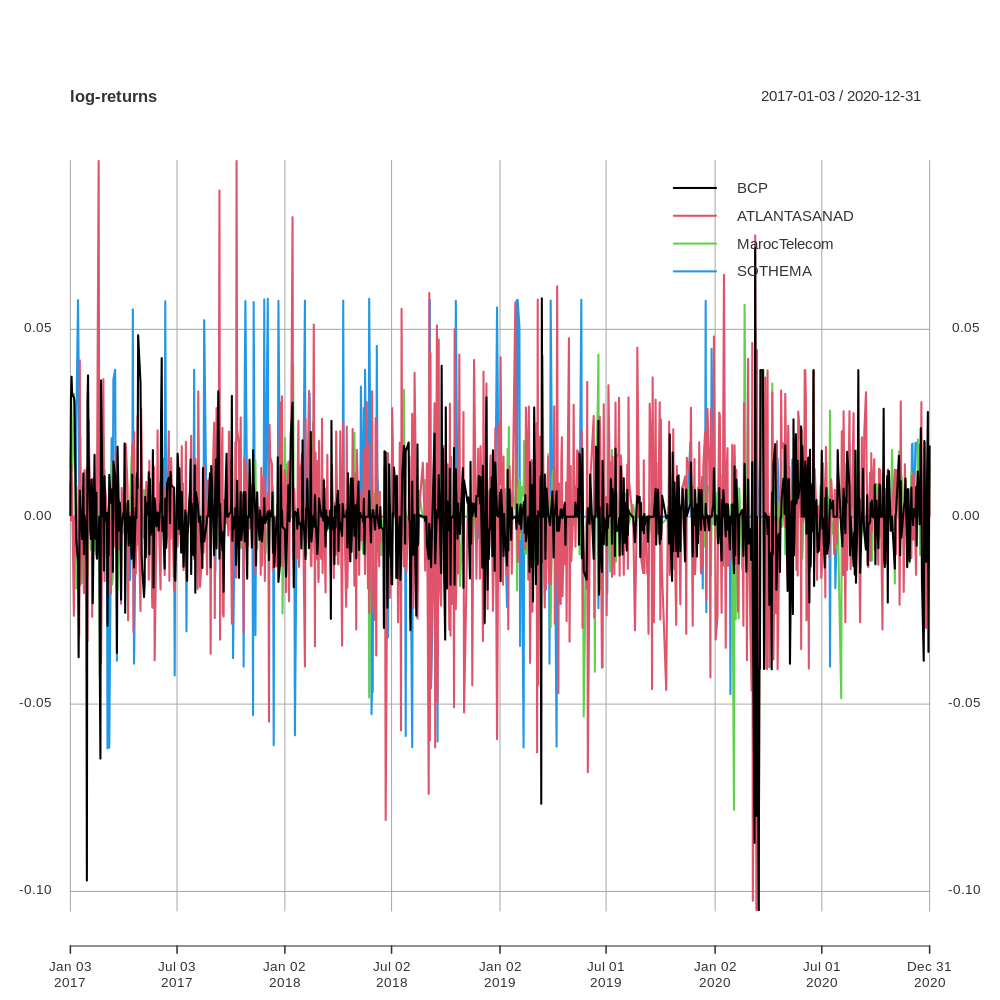

In [ ]:
p=plot.xts(logReturns, main='log-returns')
addLegend(lty=1, lwd=2)

## Continuously compounded returns (Yearly basis):

In [ ]:
yearlyReturns <- period.apply(logReturns,INDEX=endpoints(logReturns,on="years"),FUN = colSums)
head(yearlyReturns)

                    BCP ATLANTASANAD MarocTelecom    SOTHEMA
2017-12-29  0.048790164   0.24886208  -0.04665569 0.23910357
2018-12-31 -0.054214914  -0.11990802   0.07269934 0.08862119
2019-12-31 -0.005823022   0.29684287   0.06355136 0.03959256
2020-12-31 -0.119711482   0.03391654  -0.09488543 0.21010394

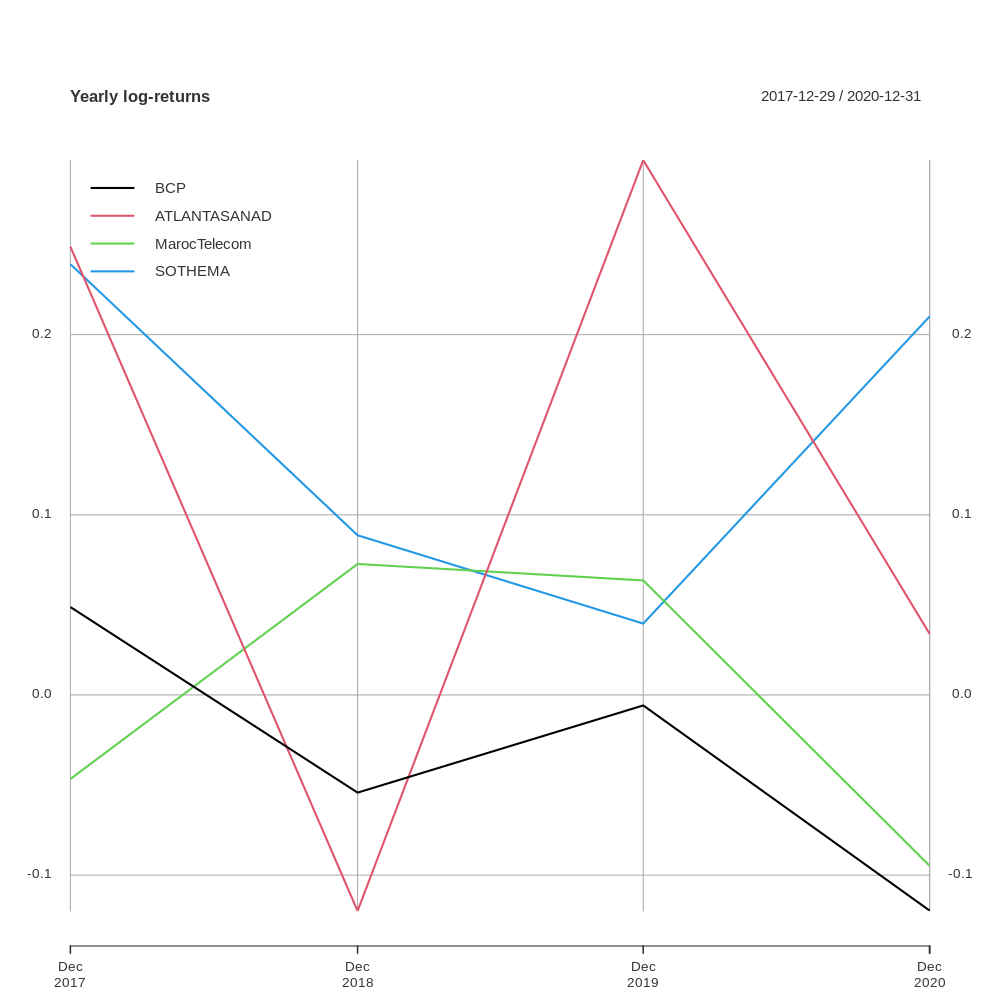

In [ ]:
p=plot.xts(yearlyReturns, main='Yearly log-returns')
addLegend(legend.loc='topleft',lty=1, lwd=2)

**Expected returns**

In [ ]:
expectedreturn = sapply(yearlyReturns, mean)
print(expectedreturn)

         BCP ATLANTASANAD MarocTelecom      SOTHEMA 
-0.032739814  0.114928368 -0.001322608  0.144355315 


**Variances-Covariance matrix**

In [ ]:
vcov= cov(yearlyReturns)
print(vcov)

                      BCP  ATLANTASANAD MarocTelecom       SOTHEMA
BCP          0.0051323007  0.0093016788  0.001532627  0.0001278582
ATLANTASANAD 0.0093016788  0.0375807240 -0.001357821  0.0004647015
MarocTelecom 0.0015326267 -0.0013578210  0.006832323 -0.0071229270
SOTHEMA      0.0001278582  0.0004647015 -0.007122927  0.0091272137


**Annualized volatility**

In [ ]:
Volats=apply.yearly(logReturns, function(x) sapply(x, sd))*sqrt(mean(nbTradingDays))

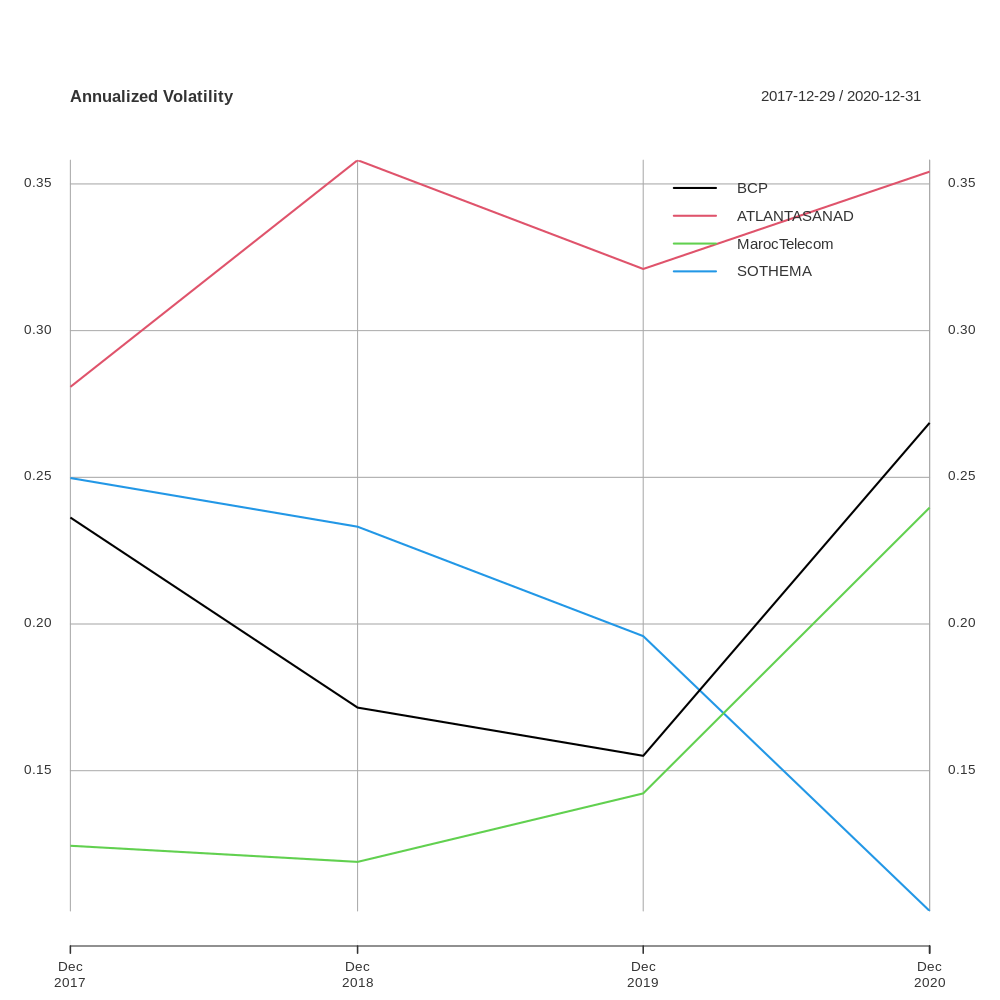

In [ ]:
p=plot.xts(Volats, main='Annualized Volatility')
addLegend(lwd=2, lty=1)

## Portfolio Optimization : 

The first problem we clearly have, is the singularity of the v-cov matrix as the number of assets equals the number of periods (years) of historical data.

In [ ]:
# Indeed : 
det(vcov %>% as.matrix())

[1] -6.563068e-25

That's why we will use the Ledoit-Wolf shrinkage estimator of the v-cov matrix : $$\color{darkred}{\widehat{\Sigma}_{\text{LW}}=(1-\beta)\widehat{\Sigma}+\beta\frac{Tr(\widehat{\Sigma})}{n}I_n}$$

Where $\beta$ is the shrinkage parameter that minimizes the MSE of the L-W estimator

In [ ]:
# Defining constraints :

LW_vcov=linshrink_cov(yearlyReturns)
Dmat = as.matrix(LW_vcov)
dvec = matrix(c(0,0,0,0), nrow=4, ncol=1)
equality = matrix(c(1,1,1,1), ncol=1)
e=matrix(c(expectedreturn[[1]], expectedreturn[[2]], expectedreturn[[3]], expectedreturn[[4]]), ncol=1)
Amat=cbind(equality, e, -diag(4))
bvec = c(1,0.15, rep(-1,4))


In [ ]:
ExpectedP = c()
sol = c()
Variance = c()
mu = seq(0, 0.15, 0.0001)
for (i in seq(1, 1501, 4)){ 
  bvec = c(1, mu[i], rep(-1,4))
  s = solve.QP(Dmat, dvec, Amat,bvec, meq=1, factorized = FALSE)
  sol[i] = s$solution[1]
  sol[i+1] = s$solution[2]
  sol[i+2] = s$solution[3]
  sol[i+3] = s$solution[4]
  Variance[i] = s$value
  ExpectedP[i] = expectedreturn[[1]]*s$solution[1]+expectedreturn[[2]]*s$solution[2]+expectedreturn[[3]]*s$solution[3]+expectedreturn[[4]]*s$solution[4]
}

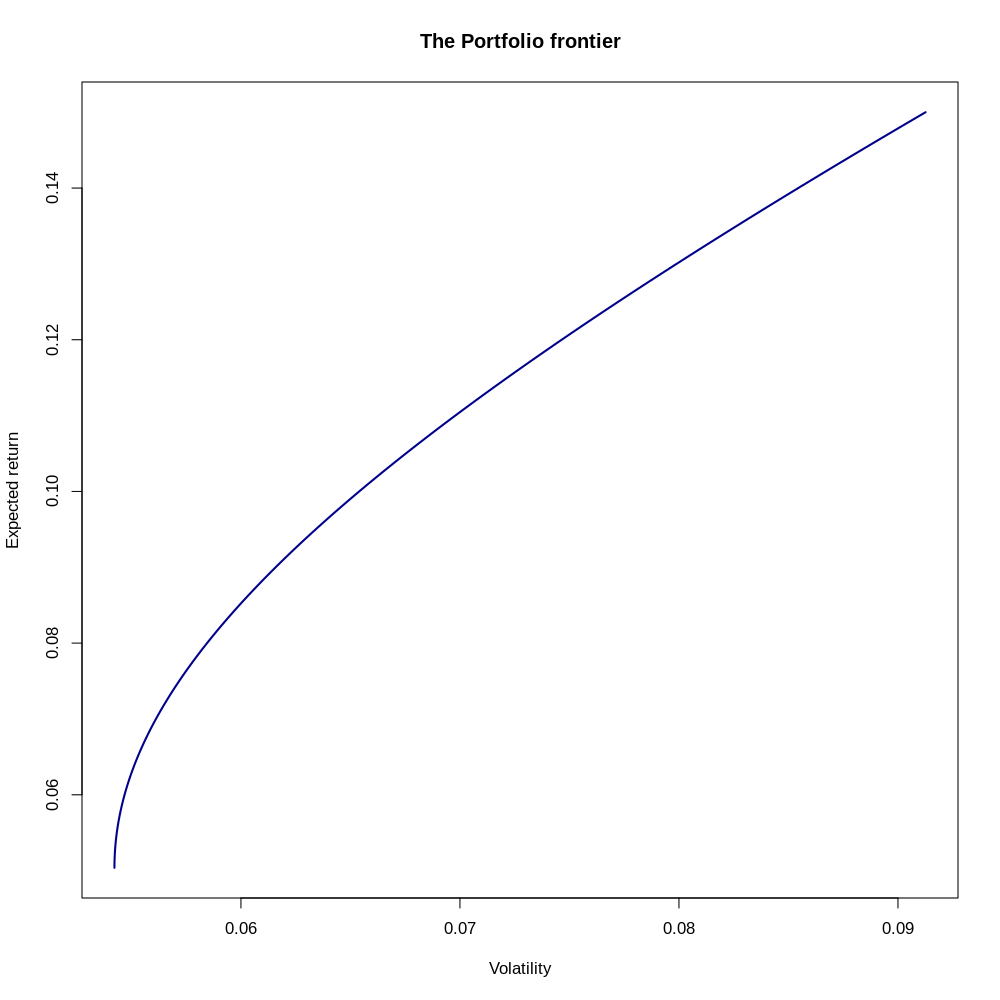

In [ ]:
#expected return

ExpectedP = na.omit(ExpectedP)
# objective
Variance = na.omit(Variance)

#standard deviation
sigmaa = sqrt(2*Variance)
plot(sigmaa, ExpectedP, type="l", lwd=2, col='darkblue', main='The Portfolio frontier', xlab='Volatility', ylab='Expected return')